# Chess Engine using Alpha-Beta Pruning

In [23]:
import chess
import chess.engine
import time
import chess.svg
from IPython.display import SVG, display

### Stockfish Static Evaluation

In [24]:
def stockfish_eval(board_instance, depth):
    # engine = chess.engine.SimpleEngine.popen_uci("./stockfish_13_linux_x64_bmi2")
    move = engine.analyse(board, chess.engine.Limit(time=0.01))
    #print(move)
    return chess.engine.PovScore(move['score'], chess.BLACK).pov(chess.BLACK).relative.score()

### Custom Static Evaluation

In [25]:
def static_eval(board):
    i = 0
    evaluation = 0
    x = True
    try:
        x = bool(board.piece_at(i).color)
    except AttributeError as e:
        x = x
    while i < 63:
        i += 1
        evaluation = evaluation + (get_piece_val(str(board.piece_at(i))) if x else -get_piece_val(str(board.piece_at(i))))
    return evaluation


In [26]:
def get_piece_val(piece):
    if(piece == None):
        return 0
    value = 0
    if piece == "P" or piece == "p":
        value = 10
    if piece == "N" or piece == "n":
        value = 30
    if piece == "B" or piece == "b":
        value = 30
    if piece == "R" or piece == "r":
        value = 50
    if piece == "Q" or piece == "q":
        value = 90
    if piece == 'K' or piece == 'k':
        value = 900
    #value = value if (board.piece_at(place)).color else -value
    return value

In [27]:
def is_favorable_move(board: chess.Board, move: chess.Move) -> bool:
    if move.promotion is not None:
        return True
    if board.is_capture(move) and not board.is_en_passant(move):
        print("MOVE", move)
        print(board.piece_type_at(move.from_square))
        print(board.piece_type_at(move.to_square))
        if get_piece_val(board.piece_type_at(move.from_square)) < get_piece_val(
            board.piece_type_at(move.to_square)
        ) or len(board.attackers(board.turn, move.to_square)) > len(
            board.attackers(not board.turn, move.to_square)
        ):
            return True
    return False

### Quiescence Search Algorithm Implementation

In [28]:
def quiescence_Search( board_instance, max_depth, current_depth, is_max_player, alpha, beta, nodes_per_depth ):
    
    # This if else code block is only used for analysis of algorithm, by counting number of nodes explored
    if max_depth-current_depth in nodes_per_depth:
        nodes_per_depth[max_depth-current_depth] += 1
    else:
        nodes_per_depth[max_depth-current_depth] = 1
    
    if current_depth == 0:
        leaf_node_score = static_eval(board_instance)
        return (leaf_node_score, nodes_per_depth)
    
    if max_depth-current_depth > 3: 
        all_possible_capture_moves = [ move for move in board_instance.legal_moves if  is_favorable_move(board_instance, move) ]
    else:
        all_possible_capture_moves = board_instance.legal_moves

    
    if is_max_player:
        
        # set absurdly high negative value such that none of the static evaluation result less than this value
        best_score = -100000 
    
        for legal_move in all_possible_capture_moves:
            move =  chess.Move.from_uci(str(legal_move))
            
            # pusshing the current move to the board
            board_instance.push(move)
            
            #calculating node score, if the current node will be the leaf node, then score will be calculated by static evaluation;
            #score will be calculated by finding max value between node score and current best score.
            node_score, nodes_per_depth = quiescence_Search(board_instance, max_depth, current_depth - 1, False, alpha, beta, nodes_per_depth)
            
            # calculating best score by finding max value between current best score and node score
            best_score = max(best_score, node_score)
            
            # undoing the last move, so as to explore new moves while backtracking
            board_instance.pop()
            
            # calculating alpha for current MAX node
            alpha = max(alpha, best_score)
            
            # beta cut off
            if beta <= alpha:
                return (best_score, nodes_per_depth)
                
        return (best_score, nodes_per_depth)
    else:
        
        # set absurdly high positive value such that none of the static evaluation result more than this value
        best_score = 100000
        
        for legal_move in all_possible_capture_moves:
            move =  chess.Move.from_uci(str(legal_move))
            
            # pushing the current move to the board
            board_instance.push(move)
            
            #calculating node score, if the current node will be the leaf node, then score will be calculated by static evaluation;
            #score will be calculated by finding min value between node score and current best score.
            node_score, nodes_per_depth = quiescence_Search(board_instance, max_depth, current_depth - 1, True, alpha, beta, nodes_per_depth)
           
            # calculating best score by finding min value between current best score and node score
            best_score = min(best_score, node_score)
            
            # undoing the last move, so as to explore new moves while backtracking
            board_instance.pop()
            
            # calculating alpha for current MIN node
            beta = min(beta, best_score)
            
            # beta cut off
            if beta <= alpha:
                return (best_score, nodes_per_depth)
            
        return (best_score, nodes_per_depth) 

### Finding Best Move using Quiescence Search Algorithm

In [29]:
def best_move_using_quiescence_search(board_instance, depth, is_max_player, alpha, beta ):
    best_move_score = -1000000
    best_move = None
    for legal_move in board_instance.legal_moves:
        move = chess.Move.from_uci(str(legal_move))
        board_instance.push(move)
        move_score, nodes_per_depth = quiescence_Search(board_instance,depth, depth, False, alpha, beta, {} )
        score = max(best_move_score, move_score)
        board_instance.pop()
        if score > best_move_score:
            best_move_score = score
            best_move = move
    return (best_move, nodes_per_depth)

### Chess Game between two Computer

In this demo game, we allow 5 move per player. 

- BLACK is MAX player.
- WHITE is MIN Player.

In [30]:
def game_between_two_computer(depth=5, moves_per_player=5):
    board = chess.Board()
    
    for n in range(0,moves_per_player*2):
        start = time.time()
        if n%2 == 0:
            print("WHITE Turn")
            move, nodes_per_depth = best_move_using_quiescence_search(board, depth, False, -10000, 10000)
        else:
            
            print("BLACK Turn")
            move, nodes_per_depth = best_move_using_quiescence_search(board, depth, True, -10000, 10000)
        end = time.time()
        
        print("Move in UCI format:", move)
        print("Nodes per depth:", nodes_per_depth)
        print("Time taken by Move:", end-start)
        board.push(move)
        display(SVG(chess.svg.board(board, size=400)))  
        print("\n")
        

In [31]:
board = chess.Board()

### Chess Board Representation before Best Move

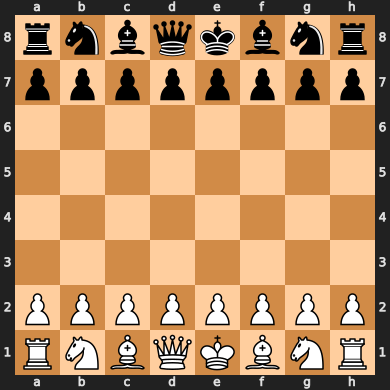

In [32]:
board

### WHITE Turn

In [33]:
move, nodes_per_depth = best_move_using_quiescence_search(board, 15, True, -100000, 100000)

MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE e8f7
6
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE c8e6
3
2
MOVE f7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE d7e6
1
2
MOVE f5e4
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h

In [34]:
move

Move.from_uci('g1h3')

In [35]:
nodes_per_depth

{0: 1, 1: 20, 2: 20, 3: 445, 4: 638, 5: 201, 6: 8}

In [36]:
board.push(move)

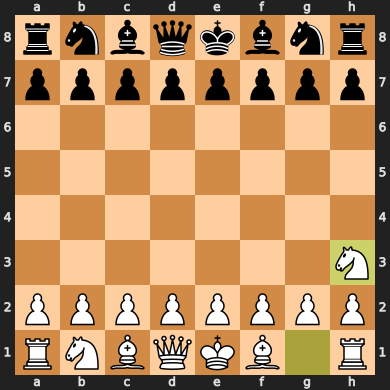

In [37]:
board

### BLACK Turn

In [38]:
move,nodes_per_depth = best_move_using_quiescence_search(board, 15, False, -100000, 100000)

MOVE h7f8
2
3
MOVE f7h8
2
4
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE e6f8
2
3
MOVE e6d8
2
5
MOVE e6g7
2
1
MOVE e6c7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g6h8
2
4
MOVE g6f8
2
3
MOVE g6e7
2
1
MOVE g6f8
2
3
MOVE g6e7
2
1
MOVE e6f8
2
3
MOVE e6d8
2
5
MOVE e6g7
2
1
MOVE e6c7
2
1
MOVE h5g7
2
1
MOVE d5e7
2
1
MOVE d5c7
2
1
MOVE c1h6
3
2
MOVE c1h6
3
2
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE c1h6
3
2
MOVE c1h6
3
2
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE d5e7
2
1
MOVE d5c7
2
1
MOVE b5c7
2
1
MOVE b5a7
2
1
MOVE c1h6
3
2
MOVE c

In [39]:
move

Move.from_uci('g8h6')

In [40]:
nodes_per_depth

{0: 1, 1: 20, 2: 20, 3: 449, 4: 485, 5: 40, 6: 4}

In [41]:
board.push(move)

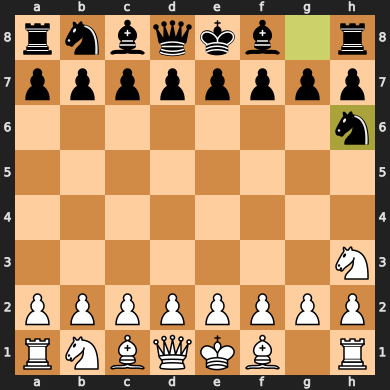

In [42]:
board

WHITE Turn
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE e8f7
6
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE c8e6
3
2
MOVE f7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8h7
4
2
MOVE e8f7
6
2
MOVE h6f7
2
2
MOVE d7e6
1
2
MOVE f5e4
1
2
MOVE h8h7
4
2
MOVE e8f7

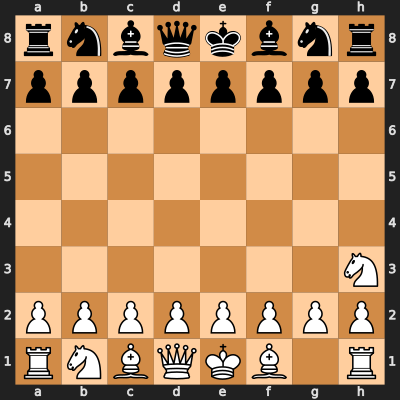



BLACK Turn
MOVE h7f8
2
3
MOVE f7h8
2
4
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE e6f8
2
3
MOVE e6d8
2
5
MOVE e6g7
2
1
MOVE e6c7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE g6h8
2
4
MOVE g6f8
2
3
MOVE g6e7
2
1
MOVE g6f8
2
3
MOVE g6e7
2
1
MOVE e6f8
2
3
MOVE e6d8
2
5
MOVE e6g7
2
1
MOVE e6c7
2
1
MOVE h5g7
2
1
MOVE d5e7
2
1
MOVE d5c7
2
1
MOVE c1h6
3
2
MOVE c1h6
3
2
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE c1h6
3
2
MOVE c1h6
3
2
MOVE g5h7
2
1
MOVE g5f7
2
1
MOVE d5e7
2
1
MOVE d5c7
2
1
MOVE b5c7
2
1
MOVE b5a7
2
1
MOVE c1

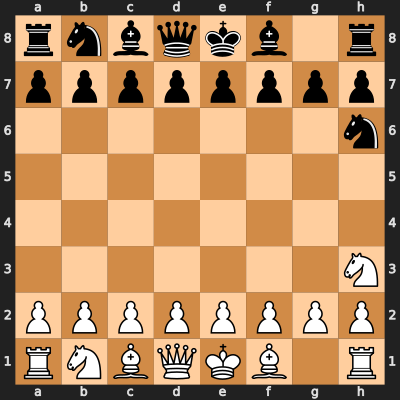



WHITE Turn
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE g4f6
2
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g4h2
2
1
MOVE g4f2
2
1
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE f6g5
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE d8f6
5
2
MOVE g7f6
1
2
MOVE d8g5
5
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE e7f6
1
2
MOVE g8g5
4
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7f6
1
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE d8f6
5
2
MOVE g7f6
1
2
MOVE d8g5
5
2
MOVE g8f8
4
2
MOVE e8f8
6
2
MOVE g7f6
1
2
MOVE e7

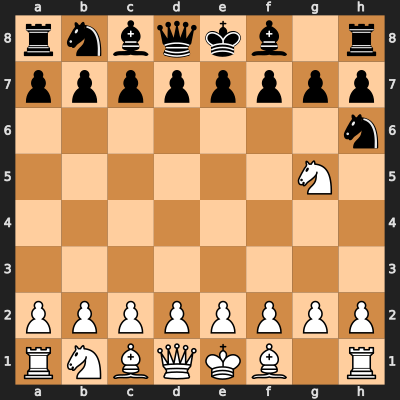



BLACK Turn
MOVE f8d7
2
1
MOVE g5f7
2
1
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE c1h6
3
2
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE c1h6
3
2
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE h7f8
2
3
MOVE d8b7
2
1
MOVE h6g8
2
4
MOVE g5h7
2
1
MOVE g5h7
2
1
MOVE e5d7
2
1
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE c1h6
3
2
MOVE g7h6
1
2
MOVE c1h6
3
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE c1h6
3
2
MOVE g7h6
1
2
MOVE c1h6
3
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7d8
2
5
MOVE f7h6
2
2
MOVE f7

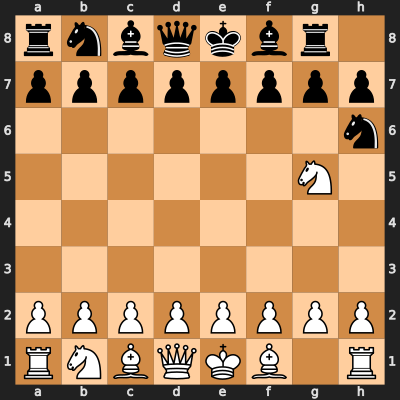



WHITE Turn
MOVE h8h7
4
2
MOVE e8d7
6
2
MOVE d8d7
5
2
MOVE c8d7
3
2
MOVE f7g6
1
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE c1h6
3
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h6g4
2
1
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE c6d4
2
1
MOVE c1h6
3
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE c6b4
2
1
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8h7
4
2
MOVE e8d7
6
2
MOVE d8d7
5
2
MOVE c8d7
3
2
MOVE f7g6
1
2
MOVE f7e6
1
2
MOVE d7e6
1
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8f8
6
2
MOVE h8f8
4
2
MOVE e8

KeyboardInterrupt: 

In [43]:
game_between_two_computer(depth=10, moves_per_player=10)

WHITE Turn
Move in UCI format: g1h3
Nodes per depth: {0: 1, 1: 20, 2: 20, 3: 445, 4: 649, 5: 212}
Time taken by Move: 4.4463114738464355


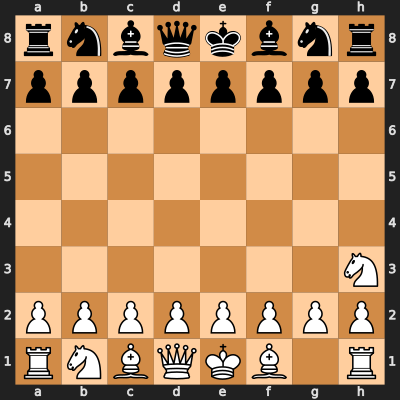



BLACK Turn
Move in UCI format: g8h6
Nodes per depth: {0: 1, 1: 20, 2: 20, 3: 449, 4: 489, 5: 40}
Time taken by Move: 2.6960885524749756


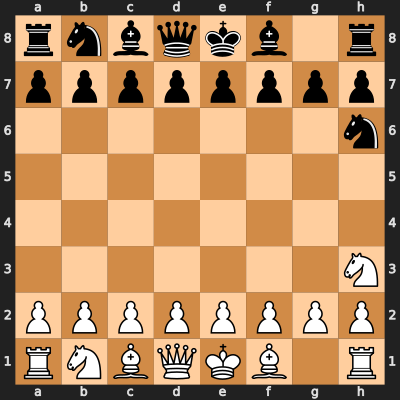



WHITE Turn
Move in UCI format: h3g5
Nodes per depth: {0: 1, 1: 20, 2: 20, 3: 426, 4: 1677, 5: 1601}
Time taken by Move: 10.320974588394165


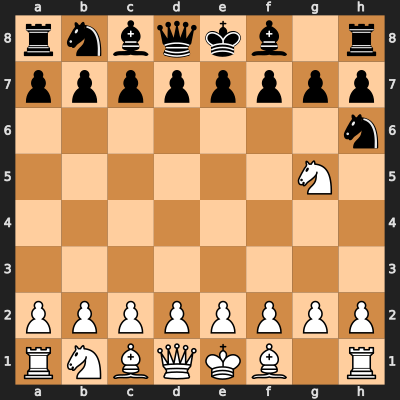



BLACK Turn
Move in UCI format: h8g8
Nodes per depth: {0: 1, 1: 25, 2: 29, 3: 768, 4: 1017, 5: 265}
Time taken by Move: 5.660167932510376


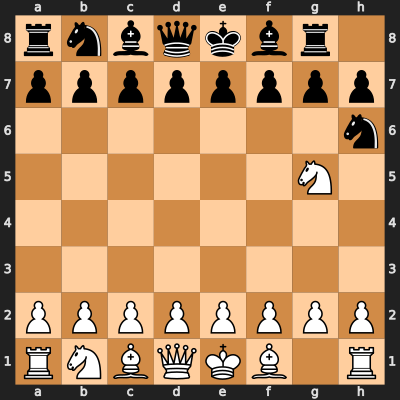



WHITE Turn
Move in UCI format: g5h7
Nodes per depth: {0: 1, 1: 18, 2: 29, 3: 588, 4: 2632, 5: 2910}
Time taken by Move: 15.559019327163696


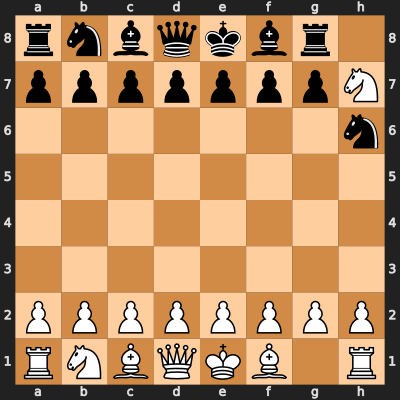



BLACK Turn
Move in UCI format: g8h8
Nodes per depth: {0: 1, 1: 22, 2: 22, 3: 528, 4: 528}
Time taken by Move: 3.538038730621338


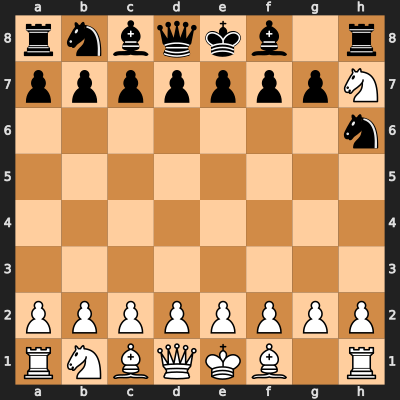



WHITE Turn
Move in UCI format: h7f6
Nodes per depth: {0: 1, 1: 21, 2: 41, 3: 566, 4: 3509, 5: 3899}
Time taken by Move: 14.94678521156311


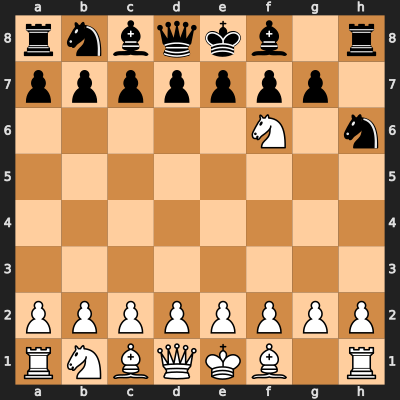



BLACK Turn
Move in UCI format: g7f6
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 0.1189267635345459


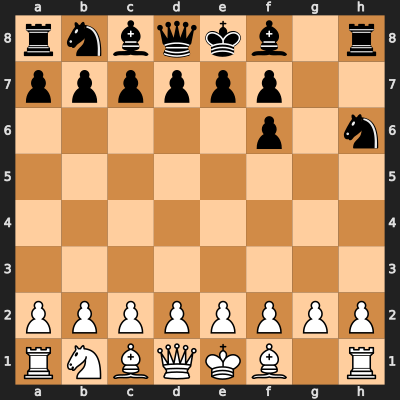



WHITE Turn
Move in UCI format: h1g1
Nodes per depth: {0: 1, 1: 19, 2: 20, 3: 448, 4: 849, 5: 504}
Time taken by Move: 5.792822360992432


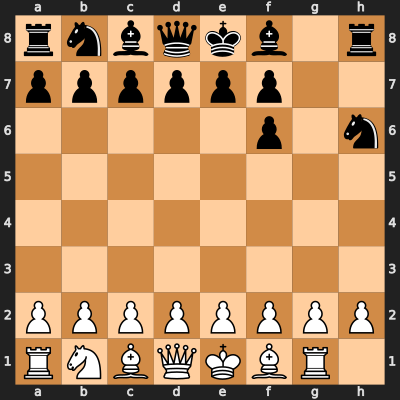



BLACK Turn
Move in UCI format: h8g8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 1.6088030338287354


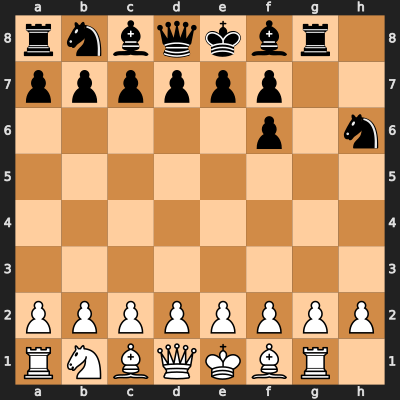



WHITE Turn
Move in UCI format: g1h1
Nodes per depth: {0: 1, 1: 23, 2: 23, 3: 576, 4: 722, 5: 172}
Time taken by Move: 6.983011722564697


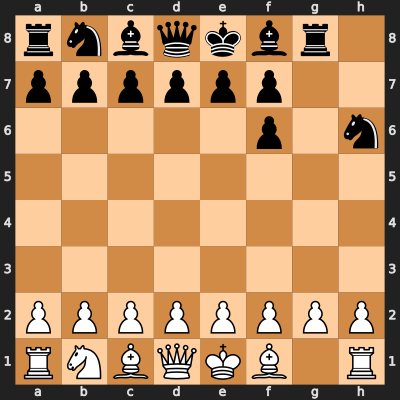



BLACK Turn
Move in UCI format: g8h8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 3.569835901260376


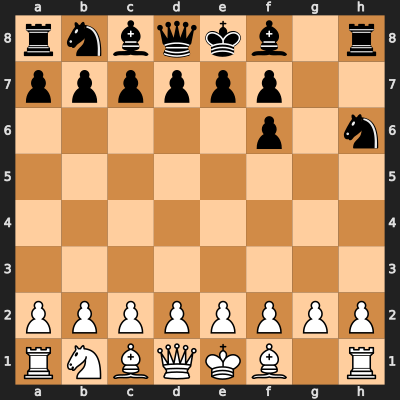



WHITE Turn
Move in UCI format: h1g1
Nodes per depth: {0: 1, 1: 19, 2: 20, 3: 448, 4: 849, 5: 504}
Time taken by Move: 6.839335918426514


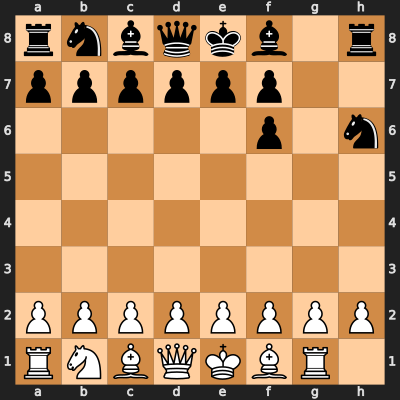



BLACK Turn
Move in UCI format: h8g8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 1.9232113361358643


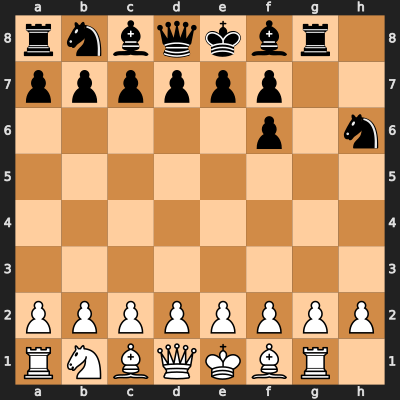



WHITE Turn
Move in UCI format: g1h1
Nodes per depth: {0: 1, 1: 23, 2: 23, 3: 576, 4: 722, 5: 172}
Time taken by Move: 6.860227346420288


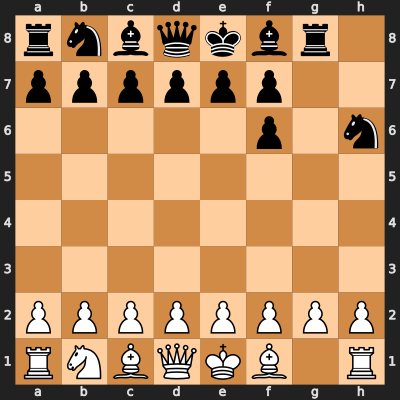



BLACK Turn
Move in UCI format: g8h8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 3.437708616256714


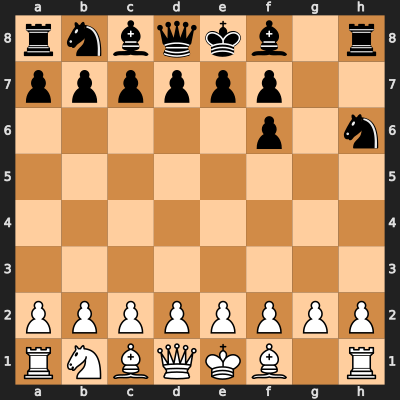



WHITE Turn
Move in UCI format: h1g1
Nodes per depth: {0: 1, 1: 19, 2: 20, 3: 448, 4: 849, 5: 504}
Time taken by Move: 7.507871389389038


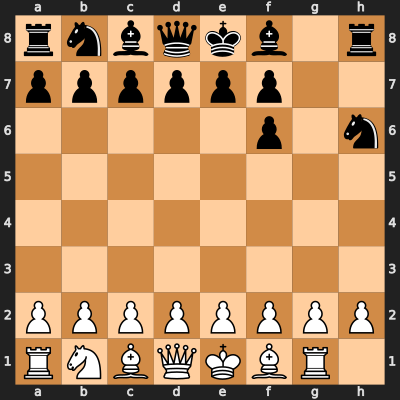



BLACK Turn
Move in UCI format: h8g8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 1.8456089496612549


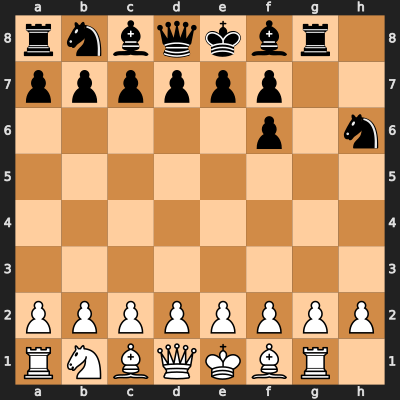



WHITE Turn
Move in UCI format: g1h1
Nodes per depth: {0: 1, 1: 23, 2: 23, 3: 576, 4: 722, 5: 172}
Time taken by Move: 6.6311445236206055


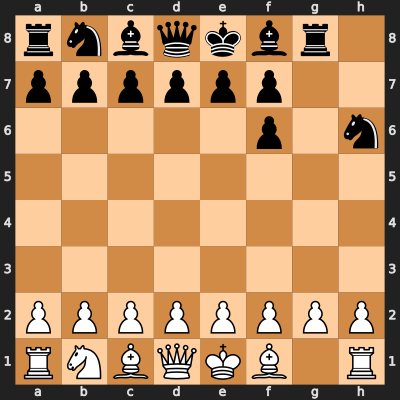



BLACK Turn
Move in UCI format: g8h8
Nodes per depth: {0: 1, 1: 19, 2: 19, 3: 404, 4: 404}
Time taken by Move: 3.4757678508758545


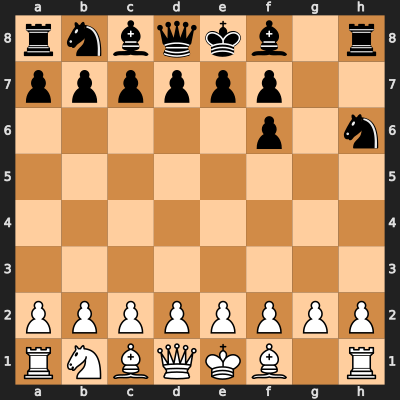

In [ ]:
game_between_two_computer(depth=5, moves_per_player=10)